# Look into Parking and Towing Logs from Cambridge Open Data

### "...You Will be Tagged and Towed"

If you live in Cambridge, MA, then you may have heard monthly megaphone messages about moving your car on street cleaning days. If your car is affected, *you will be tagged and towed*. Many people obey these rules. In my experience, those who don't seem to actually get towed. It got me curious about how much business tow operators get from street cleaning violations, so I decided to look at some tow and parking violation logs from the [Cambridge Open Data](https://data.cambridgema.gov/). I wondered what interesting tidbits I'd find there.

#### Data Sources

##### Tow Log
https://data.cambridgema.gov/Public-Safety/Tow-Log/wjk9-rveg

```All vehicles towed within the City of Cambridge reported to the Cambridge Emergency Communications Department. Includes both vehicles towed by the city (for snow emergencies, street cleaning, parking violations, etc.) and private tows (from business parking lots, etc.)```

##### Parking Ticket Log
https://data.cambridgema.gov/Traffic-Parking-and-Transportation/Cambridge-Parking-Tickets-for-the-period-January-2/vnxa-cuyr

```Cambridge Parking Tickets for the period January, 2014 through April, 2015
This layer contains the Parking Tickets issued between January 1, 2014 and April 30, 2015 (16 months worth of data) and contains tickets that were issued by both the PCO's, the Parking Control Officers, and the Cambridge Police. It does not contain Ticket Numbers or Officer Badge Numbers at the instruction of management. Nor does it contain any vehicle data or plate numbers which could inadvertently compromise privacy data.```

In [ ]:
TOW_LOG_URL = 'https://data.cambridgema.gov/api/views/wjk9-rveg/rows.csv?accessType=DOWNLOAD'
TICKETS_LOG_URL = 'https://data.cambridgema.gov/api/views/vnxa-cuyr/rows.csv?accessType=DOWNLOAD'

In [ ]:
!wget "{TOW_LOG_URL}" --no-check-certificate -O tow-log.csv
!wget "{TICKETS_LOG_URL}" --no-check-certificate -O ticket-log.csv

In [1]:
import requests
import pandas as pd
import seaborn as sns
import folium
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 8)

### Tow Data

Let's look at the tow logs first.

In [2]:
tows = pd.read_csv('tow-log.csv', parse_dates=[3])
tows.head(5)

,TrackingNumber,Classification,Location,TowedDateTime,State,Year,Make,Model,Color,TowedBy,Reason
0,15000011,PRIVATE TOWS,GENERAL LOCATIONS IN CAMBRIDGE,2015-01-01 01:16:00,MA,2004,KIA,SORENT,GRAY,-B&B TOW - PRIVATE,126 INMAN ST.
1,15000014,MV ACCIDENT B4,LANDSDOWNE ST,2015-01-01 01:25:00,MA,2010,BMW,650I,BLACK,--PAT'S TOW - CITY,ACCIDENT - MASS & FRONT
2,15000031,MV ACC NO PI,BROADWAY,2015-01-01 03:31:00,MA,NaN,NaN,NaN,NaN,--B&B TOW - CITY,ARREST - BROADWAY & GALILEO
3,15000051,MV ACCIDENT A1,2XX CAMBRIDGE ST,2015-01-01 04:43:00,MA,2013,NISS,ALTIMA,RED,--PHIL'S TOW - CITY,ARREST - CHARLES & FULKERSON
4,15000011,PRIVATE TOWS,GENERAL LOCATIONS IN CAMBRIDGE,2015-01-01 06:01:00,MA,2014,HOND,ACCORD,GRAY,ABC TOW - PRIVATE,NaN


In [3]:
print tows['TowedDateTime'].head(1)
print tows['TowedDateTime'].tail(1)
tows.index = tows['TowedDateTime']

0   2015-01-01 01:16:00
Name: TowedDateTime, dtype: datetime64[ns]
5145   2015-06-30 20:38:00
Name: TowedDateTime, dtype: datetime64[ns]


The is a half year's worth of data (Jan 1, 2015 to June 30, 2015).

Maybe plotting tows vs time would reveal something...the first plot is daily, while the second is weekly.

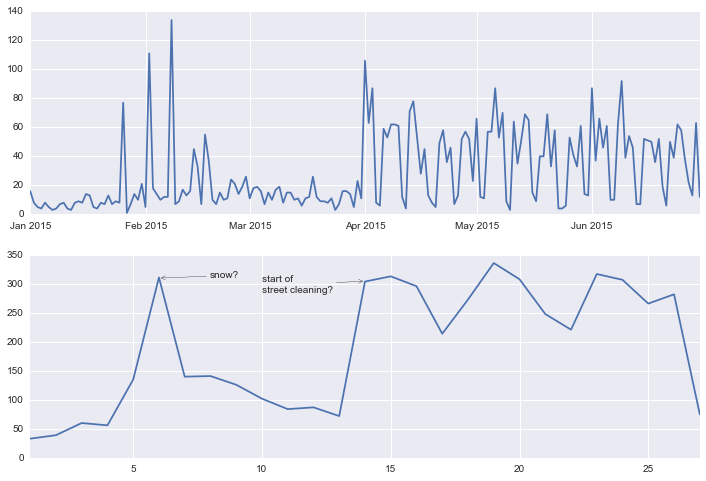

In [4]:
fig, axs = plt.subplots(2, 1)
tows.groupby(tows.index.date).count().TrackingNumber.plot(ax=axs[0])
_ = tows.groupby(tows.index.week).count().TrackingNumber.plot(ax=axs[1])

axs[1].annotate('snow?', xy=(6, 310), xytext=(8, 310),
            arrowprops=dict(arrowstyle="->", facecolor='black')
            )
axs[1].annotate('start of\nstreet cleaning?', xy=(14, 305), xytext=(10, 285),
            arrowprops=dict(arrowstyle="->", facecolor='black')
            )

There are definitely some peaks in February, and then April. I figured the winter tows would be snow-related, and the post-April tows would be street cleaning related.

Street cleaning in Cambridge is monthly, and falls on weekdays from a certain week of the months. This is consistent with the plots, if the post-April tows are indeed dominated by street cleaning tows. The complete street cleaning schedule can be found here: https://www.cambridgema.gov/theworks/ourservices/streetcleaning/schedulesandroutes

Breaking down the tow types by category reveals the street cleaning has the largest number of tows. Snow emergency makes it to the top 5.

In [5]:
tows.Classification.value_counts().head(10)

STREET CLEANING    2688
PRIVATE TOWS        787
MV OBSTRUCTING      447
SNOW EMERGENCY      325
CHECK PARKING       169
MV STOP             115
BLOCKED DRIVE        91
STATION ASSIGN       72
MV IN TOW ZONE       69
MV ACC NO PI         65
dtype: int64

Let's create some plots, with a break down by category this time. One way to do this is to dummify the categories by going from long to wide formats.

In [6]:
def dummify(df, column, categories):
    for category in categories:
        df[category] = df[column].map(lambda x: 1 if x == category else 0)
    df['OTHER'] = df[column].map(lambda x: 0 if x in categories else 1)
    return df

In [7]:
top_classifications = ['STREET CLEANING', 'PRIVATE TOWS', 'MV OBSTRUCTING', 'SNOW EMERGENCY']
tows = dummify(tows, 'Classification', top_classifications)

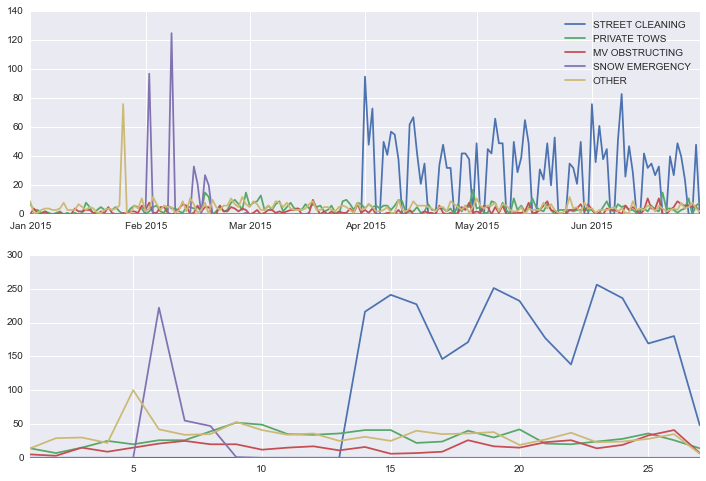

In [8]:
fig, axs = plt.subplots(2, 1)
tows.groupby(tows.index.date)[top_classifications+['OTHER']].sum().plot(ax=axs[0])
_ = tows.groupby(tows.index.week)[top_classifications+['OTHER']].sum().plot(ax=axs[1], legend=False)

The new plots confirm the suspicions of the first set. However, what's about the big spike on Jan 26 that isn't in the top categories?

In [9]:
tows['01/26/2015'].Classification.value_counts()

STATION ASSIGN     65
MV ACCIDENT B4      6
BLOCKED DRIVE       1
BLOCKED HYDRANT     1
MV STOP             1
MV OBSTRUCTING      1
MV ACCIDENT B1      1
T&P TOW REQUEST     1
dtype: int64

It looks like it's predominantly the *STATION ASSIGN* category, the meaning of which is not immediately clear.

So where do most of the towed cars end up?

In [10]:
tows['TowedBy'].value_counts()

PHIL'S TOW - CITY            1715
B&B TOW - CITY               1121
PAT'S TOW - CITY              556
--PHIL'S TOW - CITY           400
--PAT'S TOW - CITY            333
--B&B TOW - CITY              249
PAT'S TOW - PRIVATE           183
-PAT'S TOW - PRIVATE          168
PHIL'S TOW - PRIVATE          130
-PHIL'S TOW - PRIVATE          75
ROBERTS TOW - PRIVATE          63
-B&B TOW - PRIVATE             56
B&B TOW - PRIVATE              50
OTHER PRIVATE TOW-SEE REA      34
ABC TOW - PRIVATE              12
BOSTONIAN TOW - PRIVATE         1
dtype: int64

The tow operator names need a little harmonizing. Let's clean up the messy data with a pandas one-liner.

In [11]:
tows['TowedBy'].map(lambda x: x.lstrip('-')).value_counts()

PHIL'S TOW - CITY            2115
B&B TOW - CITY               1370
PAT'S TOW - CITY              889
PAT'S TOW - PRIVATE           351
PHIL'S TOW - PRIVATE          205
B&B TOW - PRIVATE             106
ROBERTS TOW - PRIVATE          63
OTHER PRIVATE TOW-SEE REA      34
ABC TOW - PRIVATE              12
BOSTONIAN TOW - PRIVATE         1
dtype: int64

So most cars end up in *Phil's*, *Pat's*, or *B&B*. If you were unlucky enough to get towed, you can use this link to do a towed vehicle lookup: https://www.cambridgema.gov/ec1/TowedVehicles.aspx

### Tickets

Since the parking violation data is also available, I thought it would be good to take a look and see how street cleaning plays into parking tickets.

In [12]:
tickets = pd.read_csv('ticket-log.csv')
tickets.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
tickets['IssueTime'].fillna('0:00 AM', inplace=True)

In [13]:
tickets.head(3)

,TicketIssueDate,IssueTime,Location,ViolationDescription,Meter
0,"January 1, 2014",1:24 AM,"OPP 240 FRANKLIN ST\nCambridge, MA\n(42.364064...",NO PARKING,NaN
1,"January 1, 2014",1:26 AM,"OPP 240 FRANKLIN ST\nCambridge, MA\n(42.364064...",NO PARKING,NaN
2,"January 1, 2014",12:50 AM,"GREEN ST @ BROOKLINE\nCambridge, MA\n(42.36342...",NO STOPPING,NaN


In [14]:
tickets['IssueTimestamp'] = pd.to_datetime(tickets['TicketIssueDate'] + ' ' + tickets['IssueTime'])
tickets.index = tickets['IssueTimestamp']

The tickets log starts Jan 2014...

In [15]:
print tickets['IssueTimestamp'].head(1)
print tickets['IssueTimestamp'].tail(1)

IssueTimestamp
2014-01-01 01:24:00   2014-01-01 01:24:00
Name: IssueTimestamp, dtype: datetime64[ns]
IssueTimestamp
2015-04-30 14:29:00   2015-04-30 14:29:00
Name: IssueTimestamp, dtype: datetime64[ns]


...so let's crop it to the beginning of 2015 to align it better with the tow log data later.

In [16]:
tickets = tickets['01/01/2015':'06/30/2015']

The *Location* column from the original data set can be split into *Address*, *CityState*, *Latitude*, and *Longitude* with a little helper function.

In [17]:
def clean_location(s):
    result = s.split('\n', 2)
    
    address = ''
    citystate = ''
    coords = '(42.366791, -71.10601)'        

    if len(result) == 1:
        coords = result[0]        

    elif len(result) == 2:
        citystate = result[0]
        coords = result[1]
        
    else:
        address = result[0]
        citystate = result[1]
        coords = result[2]

    latitude = float(coords.strip('()').split(',')[0].strip())
    longitude = float(coords.strip('()').split(',')[1].strip())

    return [address, citystate, latitude, longitude]

tickets['Address'], tickets['CityState'], tickets['Latitude'], tickets['Longitude'] = zip(*tickets['Location'].apply(clean_location))
tickets.CityState.value_counts()

Cambridge, MA    75615
MA               16392
dtype: int64

It looks like there are records that do not have the city recorded as Cambridge, MA. This is a case of missing data.

In [18]:
tickets.Address.value_counts().head(5)

LOT 5 / CENTRAL SQUARE          1181
17 QUINCY ST                     918
BINNEY ST / CARDINAL MEDEIRO     871
LOT 02 / HARVARD SQUARE          677
MAIN ST / TECHNOLOGY SQ          670
dtype: int64

The top places for parking tickets include the busy areas around Central and Harvard Squares.

In [19]:
tickets['ViolationDescription'].value_counts().head(10)

METER EXPIRED           60941
OVERTIME                 9906
RESIDENT PERMIT ONLY     7249
NO STOPPING              3264
NO PARKING               2205
LOADING ZONE             1694
LESS THAN 10FT LANE      1247
STREET CLEANING          1042
SNOW EMERG.               720
STORAGE                   513
dtype: int64

The top parking violation class, by a wide margin, is meter expiration, with street cleaning making it to the top 10.

In [20]:
top_violations = ['METER EXPIRED', 'OVERTIME', 'RESIDENT PERMIT ONLY', 'NO STOPPING', 'NO PARKING', 'STREET CLEANING']
tickets = dummify(tickets, 'ViolationDescription', top_violations)

I created some time-series plots here, just like for the tow log data.

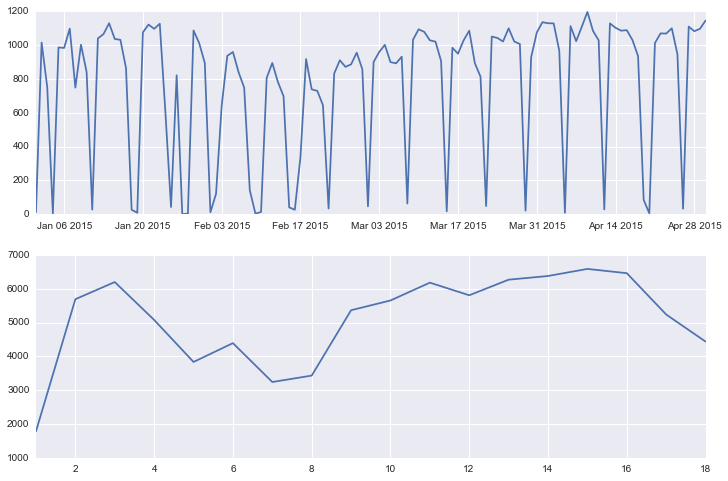

In [21]:
fig, axs = plt.subplots(2, 1)
tickets.groupby(tickets.index.date).count().ViolationDescription.plot(ax=axs[0])
_ = tickets.groupby(tickets.index.week).count().ViolationDescription.plot(ax=axs[1], legend=False)

Besides weekly cycles (no meters or resident parking enforcement on Sundays), there is a definite dip in parking citations between late January and March.

Breaking down the parkig violations by category should make analysis more clear.

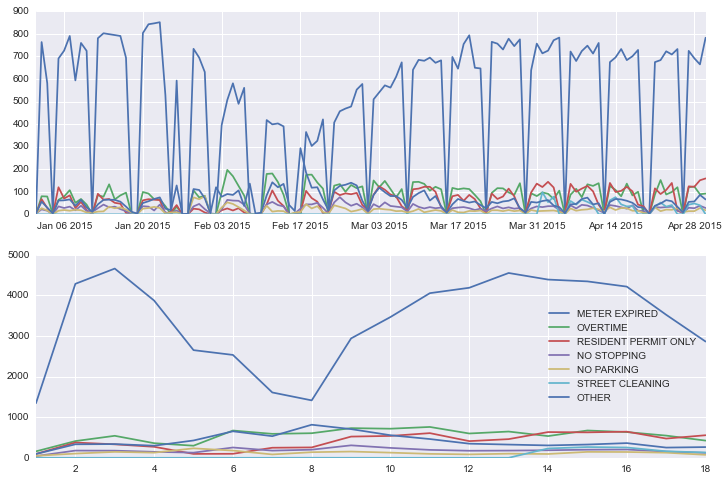

In [22]:
fig, axs = plt.subplots(2, 1)
tickets.groupby(tickets.index.date)[top_violations+['OTHER']].sum().plot(ax=axs[0], legend=False)
_ = tickets.groupby(tickets.index.week)[top_violations+['OTHER']].sum().plot(ax=axs[1])

Breaking down the parking violations by violation type shows an amplified decrease in meter violation during the winter. I was lucky enough be away most of this past winter, so can only guess that the enforcement was more lax due to extremely heavy and regular snow storms.

### Merging Parking and Tow Logs

Theoretically, the parking and tow logs datasets should be joinable based on day.

In [23]:
joined = tickets.resample('d', how={'STREET CLEANING': 'sum'}).join(tows.resample('d', how={'STREET CLEANING': 'sum'}), lsuffix=' TICKET', rsuffix=' TOW')

Let's see if the praking tickets and tows line up for street cleaning violations.

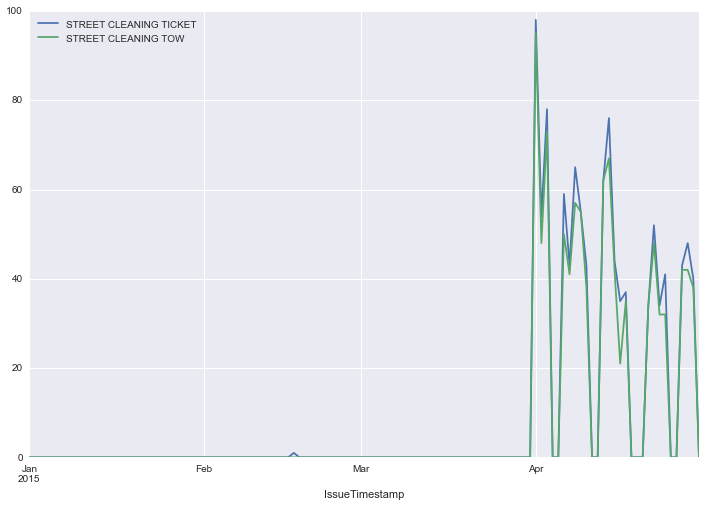

In [24]:
_ = joined[['STREET CLEANING TICKET', 'STREET CLEANING TOW']].plot()

A quick look at a plot of tickets and tows due to street cleaning shows that you're very likely to get towed if you received a street cleaning ticket. Not quite sure what that little blip in late February means. I'm not aware of street cleaning before April 1, so this is likely a clerical error.

So obey the street cleaning schedules! Obviously, the datasets do not have information on percentage of enforcement, but there's little change of getting away with just a ticket.

### Map It

No write-up on parking open data can be complete without the obligatory interactive map, so here's one that uses the [folium](https://github.com/python-visualization/folium) package. Folium is essentially a wrapper around Leaflet.js, an extremely popular JavaScript library for drawing interactive maps. It creates an HTML files that can be embedded inside a Jupyter cell.

In [25]:
# Subsample to decrease the memory load on the browser
tickets = tickets[tickets.ViolationDescription == 'STREET CLEANING']

In [26]:
locations = zip(tickets.Latitude, tickets.Longitude, tickets.Address, tickets.ViolationDescription, tickets.IssueTimestamp)

In [27]:
# This inline_map hack will no longer be necessary in next Jupyter revisions: 
# https://github.com/python-visualization/folium/issues/90
def inline_map(m, width=700, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed


width, height = 700, 500
radars = folium.Map(location=[42.366791, -71.10601], zoom_start=13,
                    tiles='OpenStreetMap', width=width, height=height)

for lat, lon, address, violation, timestamp in locations:
    radars.simple_marker(location=[lat, lon], popup='\n<br>'.join([violation, address, str(timestamp)]), clustered_marker=True)

inline_map(radars)

Try to zoom out, and you'll outliers somewhere in Worcester. This is most likely due to a geocoding error based on missing data.